# Step 3: Training Models and Generating Predictions
Using our cleaned datasets, we train our machine learning models and generate predictions. These will output performance plots that display best classifiers and best hyperparameters for a given classifier.
**NOTE:** This notebook will take over several to train on all our data and generate plots. For faster times, please set a condensed date range, though note that too small a range may yield errors due to no positive classifications being found

In [3]:
DATA_DIR = '../data'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.tree
import sklearn.metrics
import sklearn.ensemble
import sklearn.preprocessing
import sklearn.model_selection   # For cross_val_score, GridSearchCV, RandomizedSearchCV
import pandas as pd
plt.rcParams.update({'figure.max_open_warning': 0})

In [5]:
import importlib
def train_estimators(X, y, estimator_type, param_name, param_vals, **kwargs):
    train_estimator = [] 
    s = "%s" %kwargs #converts kwargs to string 
    s = str(estimator_type).split("'")[1]      #gets import_module which is sklearn.tree 
    position1 = (s.find("."))
    position2 = (s.find(".",position1+1))
    
    for i in range(len(param_vals)):
        model_class = getattr(importlib.import_module(s[:position2]),(str(estimator_type).split(".")[-1][:-2]))
        kwargs[param_name] = param_vals[i] #adds param_name into the kwargs dictionnary
        model = model_class(**kwargs)  # instantiates the model
        train_estimator.append(model.fit(X,y))
        #print(f' Training {train_estimator[i]}...')
    return train_estimator

def score_estimators(X, y, estimators):
    score = []
    for i in range(np.array(estimators).shape[0]):
         score.append(estimators[i].score(X,y))
    return score

def plot_estimator_scores(estimators, param_name, param_vals, X_trn, ytrn, X_val, yval, X_test, ytest, name):
    train_score,val_score,test_score = [],[],[]
    train_score = np.average([score_estimators(X_trn,ytrn,e) for e in estimators], axis=1).tolist()
    val_score = np.average([score_estimators(X_val,yval,e) for e in estimators], axis=1).tolist()
    test_score = np.average([score_estimators(X_test,ytest,e) for e in estimators], axis=1).tolist()
    #print(np.array([score_estimators(X_test,ytest,e) for e in estimators]))
    #print(test_score)
    #finding best scores  
    best_val = max(np.array(val_score))
    index = val_score.index(best_val)
    
    best_train = train_score[index]
    best_test = test_score[index]
    
    min_score = np.concatenate((train_score,val_score,test_score))
    best_score = np.concatenate((train_score,val_score,test_score))
    #plotting code
    #makes sure the x axis points are evenly spaced
    locs, labels = plt.xticks() 
    plt.plot(locs,np.array(train_score).ravel(),'-o',color='green',label='train = %.3f' %(best_train))
    plt.plot(locs,val_score,'-o',color='red',label='validate = %.3f' %(best_val))
    plt.plot(locs,test_score,linestyle='dotted',color='black',label='test = %.3f' %(best_test))
    
    plt.scatter(locs[index],best_val, s=150, marker='x',color="red")
    plt.xticks(locs,param_vals)
    #plt.ylim(min(min_score)-0.02,max(best_score)+0.01)
    plt.ylim(0,1)
    plt.legend(loc="center left")
    plt.xlabel(param_name)
    plt.ylabel("score")
    plt.title(f'({name}) {estimators[0].__class__.__name__} score vs {param_name}')

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.tree
import sklearn.metrics
import sklearn.ensemble
import sklearn.preprocessing
import sklearn.model_selection   # For cross_val_score, GridSearchCV, RandomizedSearchCV
import pandas as pd
import warnings
plt.rcParams.update({'figure.max_open_warning': 0})
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

estimators = {}

def trainForY(X, data, yname):
    print('===========================================================')
    print(yname)
    estimators[yname] = {}
    
    y = data[yname]
    y = y.values
    tscv = TimeSeriesSplit()
    #(trn_1, tst_1), (trn_2, tst_2), (trn_3, tst_3), (trn_4, tst_4), (trn_5, tst_5) = tscv.split(X)
    #X_trn_1, X_val_1, y_trn_1, y_val_1 = sklearn.model_selection.train_test_split(trn_1, trn_1, test_size=0.25, random_state=0)
    #X_trn_2, X_val_2, y_trn_2, y_val_2 = sklearn.model_selection.train_test_split(trn_2, trn_2, test_size=0.25, random_state=0)
    ###X_trn_3, X_val_3, y_trn_3, y_val_3 = sklearn.model_selection.train_test_split(trn_3, trn_3, test_size=0.25, random_state=0)
    ##X_trn_4, X_val_4, y_trn_4, y_val_4 = sklearn.model_selection.train_test_split(trn_4, trn_4, test_size=0.25, random_state=0)
    #X_trn_5, X_val_5, y_trn_5, y_val_5 = sklearn.model_selection.train_test_split(trn_5, trn_5, test_size=0.25, random_state=0)
    
    #cv_results = cross_val_score( sklearn.linear_model.LogisticRegression(), X, y, cv=[[X_trn_1, y_trn_1], [X_trn_2, y_trn_2]], scoring='r2')
    #print(cv_results)
    #return
    

    tree_estimators =  [[], [], [], [], [], []]
    forest =  [[], [], [], [], [], []]
    logistic =  [[], [], [], [], [], []]
    svm =  [[], [], [], [], [], []]
    
    warnings.filterwarnings('ignore', 'Solver terminated early.*')
    it = 1
    print(f'Total length: {len(X)}')
    for train_index, test_index in tscv.split(X):
        print('---------------------------')
        print(f'Iteration {it}')
        it += 1
        X_trn, X_tst = X[train_index], X[test_index]
        y_trn, y_tst = y[train_index], y[test_index]   
        val_split = round(len(X_trn)*.75)
        X_val = X_trn[val_split:]
        X_trn = X_trn[:val_split]
        y_val = y_trn[val_split:]
        y_trn = y_trn[:val_split]
        print(f'Training length: {len(X_trn)}')
        print(f'Validation length: {len(X_val)}')
        print(f'Test length: {len(X_tst)}')
        #X_trn, X_val, y_trn, y_val = sklearn.model_selection.train_test_split(X_trn, y_trn, test_size=0.25, random_state=0)
        
        scaler = sklearn.preprocessing.StandardScaler()
        X_trn = scaler.fit_transform(X_trn.reshape(X_trn.shape[0],-1))
        X_tst = scaler.transform(X_tst.reshape(X_tst.shape[0],-1))
        X_val = scaler.transform(X_val.reshape(X_val.shape[0],-1))
        
        print("trees...")
        tree_estimators_temp = train_estimators(X_trn, y_trn, sklearn.tree.DecisionTreeClassifier, 'max_depth', [1, 5, 10, 20, 50, 100], splitter='random', random_state=0)
        for i, est in enumerate(tree_estimators_temp):
            tree_estimators[i].append(est)
        
        print("forests...")
        forest_temp = train_estimators(X_trn, y_trn, sklearn.ensemble.RandomForestClassifier, 'max_depth', [1, 5, 10, 20, 50, 100], random_state=0)
        for i, est in enumerate(forest_temp):
            forest[i].append(est)
            
        print("logistic...")
        logistic_temp = train_estimators(X_trn, y_trn, sklearn.linear_model.LogisticRegression, 'C', [1e-05, 0.0001, 0.001, 0.01, 0.1,1.0], max_iter=10000,random_state=0)
        for i, est in enumerate(logistic_temp):
            logistic[i].append(est)
            
        print("svm...")
        svm_temp = train_estimators(X_trn, y_trn, sklearn.svm.SVC, 'C', [0.01, 0.1,1.0, 10.0, 100.0,1000.0], gamma=0.001,max_iter=100,random_state=0)
        for i, est in enumerate(svm_temp):
            svm[i].append(est)
       

    estimators[yname]['tree'] = tree_estimators
    estimators[yname]['forest'] = forest
    estimators[yname]['logistic'] = logistic
    estimators[yname]['svm'] = svm
    fig = plt.figure(figsize=(20,10))
    fig.suptitle(yname)
    fig.add_subplot(2,2,1)
    plot_estimator_scores(tree_estimators,'max_depth',[1, 5, 10, 20, 50, 100], X_trn, y_trn, X_val, y_val, X_tst, y_tst, 'Tree')
    fig.add_subplot(2,2,2)
    plot_estimator_scores(forest,'max_depth',[1, 5, 10, 20, 50, 100], X_trn, y_trn, X_val, y_val, X_tst, y_tst, 'Forest')
    fig.add_subplot(2,2,3)
    plot_estimator_scores(logistic,'C',[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0], X_trn, y_trn, X_val, y_val, X_tst, y_tst, 'Logististic')
    fig.add_subplot(2,2,4)
    plot_estimator_scores(svm,'C',[0.01, 0.1,1.0, 10.0, 100.0,1000.0], X_trn, y_trn, X_val, y_val, X_tst, y_tst, 'SVM')


def trainFromFile(file, yname):
    estimators ={}
    data = pd.read_csv(file)
    
    #data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
    #data = data.dropna(axis=1)
    #for col in data.columns:
    #    print(col)
    X = data.drop(["date","ticker", 'close', 'today_close',
                   "tomorrw_is_buy","tomorrow_is_strong_buy", "tomorrow_increase","tomorrow_close",
                   "week_is_buy","week_is_strong_buy",  "week_increase",
                   "4week_is_buy", "4week_close", "4week_is_strong_buy"],axis=1)
    #X = data.drop(["date","ticker"],axis=1)
    #print(X.head())
    
    for i, col in enumerate(X.columns):
        print(str(i) + ': ' + col)
    X = X.values
    
    
    trainForY(X, data, yname)


In [7]:
ests = [None] * 16

In [ ]:
trainFromFile('../data/out.csv', 'tomorrw_is_buy')
ests[0] = estimators

0: score_neg
1: score_neu
2: score_pos
3: score_compound
4: parent_score_neg
5: parent_score_neu
6: parent_score_pos
7: parent_score_compound
8: score
9: parent_score
10: submission_score
11: is_root
12: submission_ratio
13: parent_ratio
14: num_replies
15: day_increase
16: volume
tomorrw_is_buy
Total length: 401598
---------------------------
Iteration 1
Training length: 50200
Validation length: 16733
Test length: 66933
trees...
forests...
logistic...
svm...
---------------------------
Iteration 2
Training length: 100400
Validation length: 33466
Test length: 66933
trees...
forests...
logistic...
svm...
---------------------------
Iteration 3
Training length: 150599
Validation length: 50200
Test length: 66933
trees...
forests...
logistic...
svm...
---------------------------
Iteration 4
Training length: 200799
Validation length: 66933
Test length: 66933
trees...
forests...


0: score_neg
1: score_neu
2: score_pos
3: score_compound
4: parent_score_neg
5: parent_score_neu
6: parent_score_pos
7: parent_score_compound
8: score
9: parent_score
10: submission_score
11: is_root
12: submission_ratio
13: parent_ratio
14: num_replies
15: day_increase
16: volume
tomorrow_is_strong_buy
Total length: 401598
---------------------------
Iteration 1
Training length: 50200
Validation length: 16733
Test length: 66933
trees...
forests...
logistic...
svm...
---------------------------
Iteration 2
Training length: 100400
Validation length: 33466
Test length: 66933
trees...
forests...
logistic...
svm...
---------------------------
Iteration 3
Training length: 150599
Validation length: 50200
Test length: 66933
trees...
forests...
logistic...
svm...
---------------------------
Iteration 4
Training length: 200799
Validation length: 66933
Test length: 66933
trees...
forests...
logistic...
svm...
---------------------------
Iteration 5
Training length: 250999
Validation length: 8366

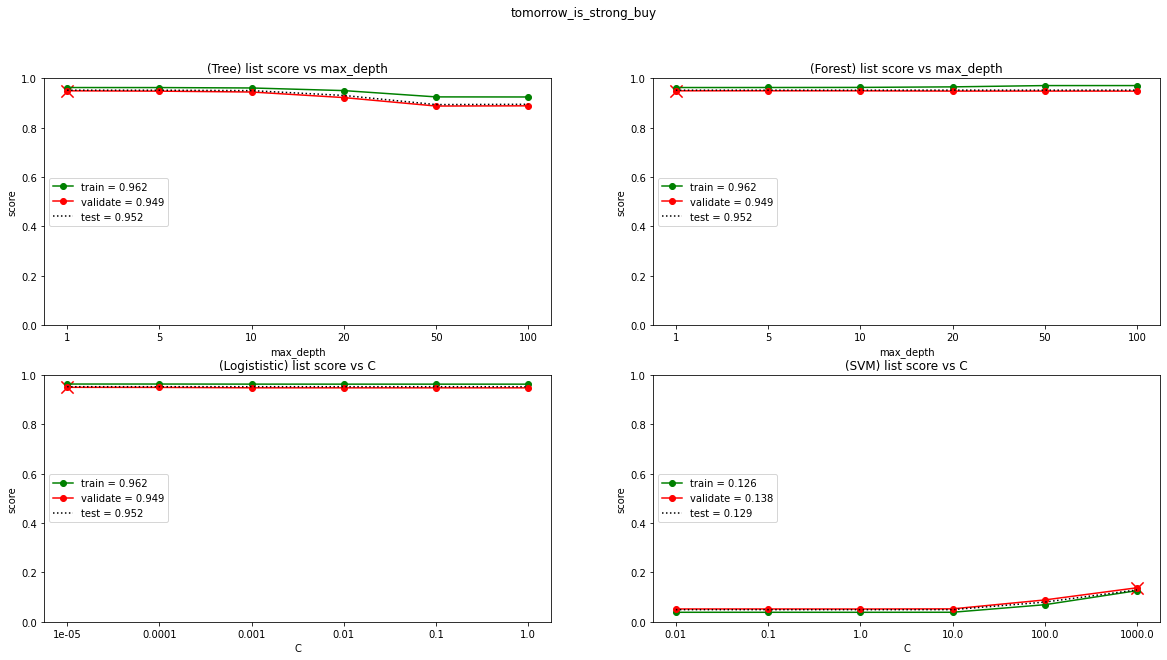

In [10]:
trainFromFile('../data/out.csv', 'tomorrow_is_strong_buy')
ests[1] = estimators

0: score_neg
1: score_neu
2: score_pos
3: score_compound
4: parent_score_neg
5: parent_score_neu
6: parent_score_pos
7: parent_score_compound
8: score
9: parent_score
10: submission_score
11: is_root
12: submission_ratio
13: parent_ratio
14: num_replies
15: day_increase
16: volume
week_is_buy
Total length: 401598
---------------------------
Iteration 1
Training length: 50200
Validation length: 16733
Test length: 66933
trees...
forests...
logistic...
svm...
---------------------------
Iteration 2
Training length: 100400
Validation length: 33466
Test length: 66933
trees...
forests...
logistic...
svm...
---------------------------
Iteration 3
Training length: 150599
Validation length: 50200
Test length: 66933
trees...
forests...
logistic...
svm...
---------------------------
Iteration 4
Training length: 200799
Validation length: 66933
Test length: 66933
trees...
forests...
logistic...
svm...
---------------------------
Iteration 5
Training length: 250999
Validation length: 83666
Test leng

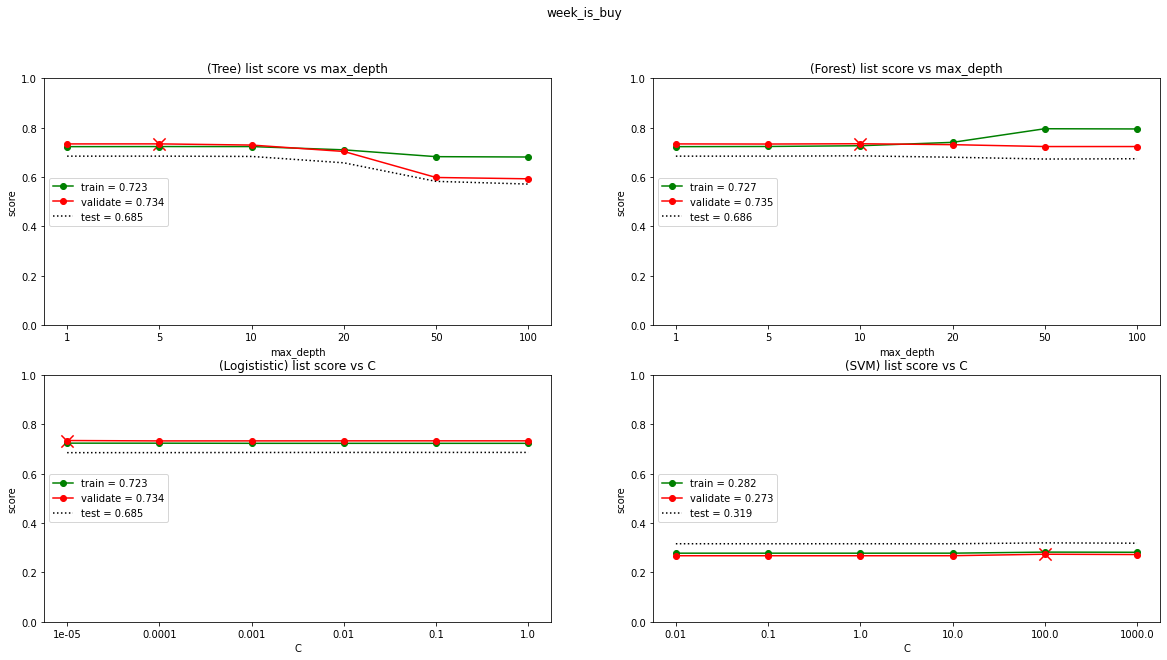

In [11]:
trainFromFile('../data/out.csv', 'week_is_buy')
ests[2] = estimators

0: score_neg
1: score_neu
2: score_pos
3: score_compound
4: parent_score_neg
5: parent_score_neu
6: parent_score_pos
7: parent_score_compound
8: score
9: parent_score
10: submission_score
11: is_root
12: submission_ratio
13: parent_ratio
14: num_replies
15: day_increase
16: volume
week_is_strong_buy
Total length: 401598
---------------------------
Iteration 1
Training length: 50200
Validation length: 16733
Test length: 66933
trees...
forests...
logistic...
svm...
---------------------------
Iteration 2
Training length: 100400
Validation length: 33466
Test length: 66933
trees...
forests...
logistic...
svm...
---------------------------
Iteration 3
Training length: 150599
Validation length: 50200
Test length: 66933
trees...
forests...
logistic...
svm...
---------------------------
Iteration 4
Training length: 200799
Validation length: 66933
Test length: 66933
trees...
forests...
logistic...
svm...
---------------------------
Iteration 5
Training length: 250999
Validation length: 83666
Te

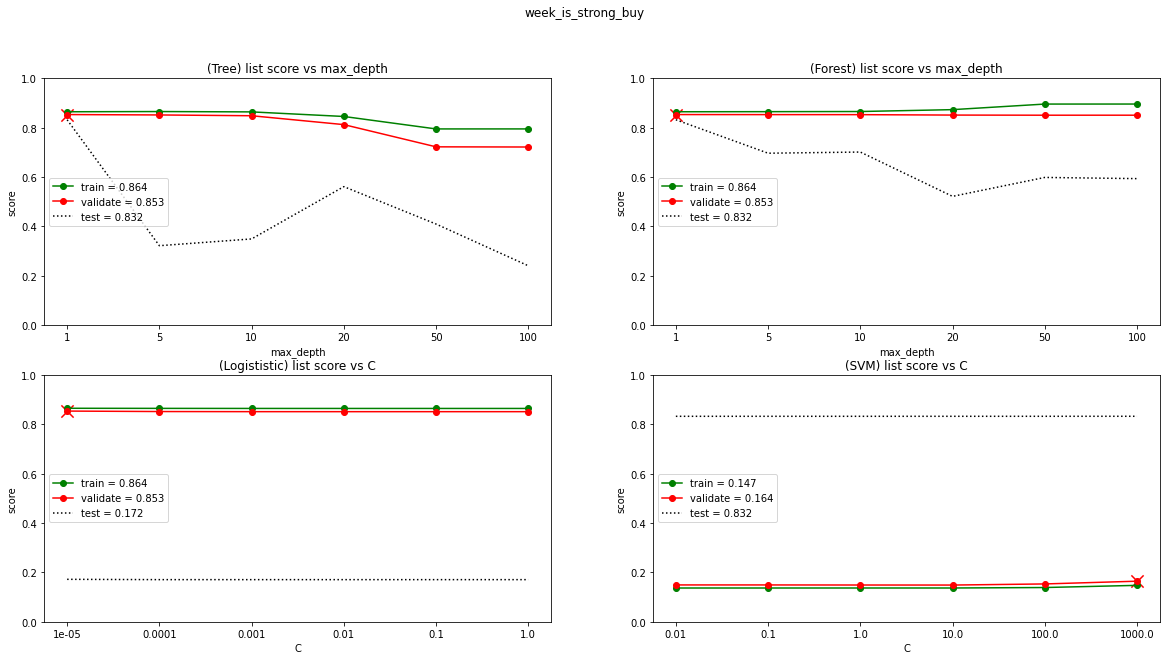

In [114]:
trainFromFile('../data/out.csv', 'week_is_strong_buy')
ests[3] = estimators

In [ ]:
trainFromFile('../data/out.csv', '4week_is_buy')
ests[4] = estimators

0: score_neg
1: score_neu
2: score_pos
3: score_compound
4: parent_score_neg
5: parent_score_neu
6: parent_score_pos
7: parent_score_compound
8: score
9: parent_score
10: submission_score
11: is_root
12: submission_ratio
13: parent_ratio
14: num_replies
15: day_increase
16: volume
4week_is_buy
Total length: 401598
---------------------------
Iteration 1
Training length: 50200
Validation length: 16733
Test length: 66933
trees...
forests...
logistic...
svm...
---------------------------
Iteration 2
Training length: 100400
Validation length: 33466
Test length: 66933
trees...
forests...


In [ ]:
trainFromFile('../data/out.csv', '4week_is_strong_buy')
ests[5] = estimators

In [ ]:
trainFromFile('../data/out2.csv', 'tomorrw_is_buy')
ests[6] = estimators

0: score_neg
1: score_neu
2: score_pos
3: score_compound
4: parent_score_neg
5: parent_score_neu
6: parent_score_pos
7: parent_score_compound
8: score
9: parent_score
10: submission_score
11: is_root
12: submission_ratio
13: parent_ratio
14: num_replies
15: day_increase
16: volume
tomorrw_is_buy
Total length: 313685
---------------------------
Iteration 1
Training length: 39214
Validation length: 13071
Test length: 52280
trees...
forests...
logistic...
svm...
---------------------------
Iteration 2
Training length: 78424
Validation length: 26141
Test length: 52280
trees...
forests...
logistic...
svm...
---------------------------
Iteration 3
Training length: 117634
Validation length: 39211
Test length: 52280
trees...
forests...
logistic...
svm...
---------------------------
Iteration 4
Training length: 156844
Validation length: 52281
Test length: 52280
trees...
forests...
logistic...
svm...
---------------------------
Iteration 5
Training length: 196054
Validation length: 65351
Test le

In [ ]:
trainFromFile('../data/out2.csv', 'tomorrow_is_strong_buy')
ests[7] = estimators

In [ ]:
trainFromFile('../data/out2.csv', 'week_is_buy')
ests[8] = estimators

In [ ]:
trainFromFile('../data/out2.csv', 'week_is_strong_buy')
ests[9] = estimators

In [ ]:
trainFromFile('../data/out2.csv', '4week_is_buy')
ests[10] = estimators

In [ ]:
trainFromFile('../data/out2.csv', '4week_is_strong_buy')
ests[11] = estimators